In [11]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [12]:
customer_data= pd.read_csv('AdvWorksCustsPrep.csv')
print(customer_data)

       Unnamed: 0  CustomerID        Education      Occupation Gender  \
0               0       11000       Bachelors     Professional      M   
1               1       11001       Bachelors     Professional      M   
2               2       11002       Bachelors     Professional      M   
3               3       11003       Bachelors     Professional      F   
4               4       11004       Bachelors     Professional      F   
...           ...         ...              ...             ...    ...   
16399       16514       13121       Bachelors     Professional      F   
16400       16515       26100  Partial College    Professional      F   
16401       16516       11328       Bachelors       Management      M   
16402       16517       23077      High School  Skilled Manual      M   
16403       16518       18982      High School    Professional      M   

       NumberCarsOwned  NumberChildrenAtHome  TotalChildren  YearlyIncome  \
0                    0                     0  

## Prepare the model matrix.

### We use one hot encoding for categorical features

In [21]:
print(customer_data['Education'].unique())
Features = customer_data['Education']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print(Features)
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features.reshape(-1,1))
Features = encoded.transform(Features.reshape(-1,1)).toarray()
Features[:10,:]

['Bachelors ' 'Partial College' 'High School' 'Partial High School'
 'Graduate Degree']
[0 0 0 ... 0 2 2]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [22]:

def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    

categorical_columns = [ 'Occupation', 'Gender', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', ]

for col in categorical_columns:
    temp = encode_string(customer_data[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :]) 

(16404, 29)
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0.]]


### Add the numeric features

To complete the model matrix, execute the code in the cell below to concatenate the three numeric features.

In [23]:
Features = np.concatenate([Features, np.array(customer_data[['YearlyIncome']])], axis = 1)
Features[:2,:]

array([[1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.37947e+05],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.01141e+05]])

## Split the dataset

With the model matrix constructed, you must now create randomly sampled training and test data sets. The code in the cell below uses the `train_test_split` function from the `sklearn.model_selection` module to Bernoulli sample the cases in the original dataset into the two subsets. Since this data set is small only 40 cases will be included in the test dataset. Execute this code. 

In [41]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
labels = np.array(customer_data['AveMonthSpend'])
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 8000)
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

### Rescale numeric features

Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables. 

The code in the cell below uses the `StandardScaler` function from the Scikit Learn preprocessing package to Zscore scale the numeric features. Notice that the scaler is fit only on the training data. The trained scaler is these applied to the test data. Test data should always be scaled using the parameters from the training data. 

Execute this code.

In [42]:
scaler = preprocessing.StandardScaler().fit(x_train[:,14:])
x_train[:,14:] = scaler.transform(x_train[:,14:])
x_test[:,14:] = scaler.transform(x_test[:,14:])
print(x_train.shape)
x_train[:5,:]

(8404, 30)


array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  1.        , -0.73929609,
        -0.30703556, -0.26999392,  0.80388381, -0.38908945, -0.31004234,
        -0.26256276, -0.24612084, -0.23363759, -0.59329154,  2.087988  ,
        -0.48717353, -0.36938265, -0.39695813, -0.34264355,  0.42837076],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.35263803,
        -0.30703556, -0.26999392, -1.24396086,  2.57010308, -0.31004234,
        -0.26256276, -0.24612084, -0.23363759, -0.59329154, -0.47892996,
         2.05265669, -0.36938265, -0.39695813, -0.34264355,  0.04543828],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

# Construct the linear regression model

With data prepared and split into training and test subsets, you will now compute the linear regression model. With the dummy variables created there are 17 features, so the model will require 17 coefficients. There is no intercept specified since we are working with dummy variables. The equation for such a **multiple regression** problem can be written as:

In [31]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

<b>The model has been fit to the training data. Execute the code in the cell below to examine the value of the intercept term and coefficients.</b> 

In [33]:
print(lin_mod.intercept_)
print(lin_mod.coef_)

0.0
[-3.79566863e+13 -3.79566863e+13 -3.79566863e+13 -3.79566863e+13
 -3.79566863e+13  8.04210568e+12  8.04210568e+12  8.04210568e+12
  8.04210568e+12  8.04210568e+12  2.51941100e+13  2.51941100e+13
  9.58464241e+12  9.58464241e+12  4.58171333e+12  2.68930317e+12
  2.41197048e+12 -1.49437471e+11 -1.03414943e+11 -8.65599412e+10
 -7.51686309e+10 -7.10171646e+10 -6.77980213e+10  1.56009071e+11
  1.38498396e+11  1.39975506e+11  1.15554100e+11  1.21913559e+11
  1.09015646e+11  8.22808721e+00]


## Evaluate the model

You will now use the test dataset to evaluate the performance of the regression model. As a first step, execute the code in the cell below to compute and display various performance metrics and examine the results.

In [43]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 5000)

Mean Square Error      = 47.10321806491492
Root Mean Square Error = 6.863178422925848
Mean Absolute Error    = 5.199407623291016
Median Absolute Error  = 4.0947265625
R^2                    = 0.9369581449258487
Adjusted R^2           = 0.8319094004206213


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


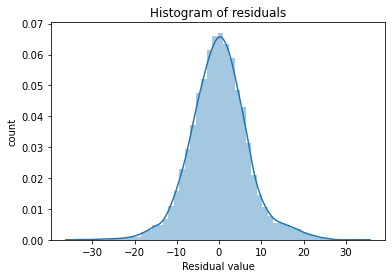

In [44]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)   

Since this is a normal distribution the model seems to work well

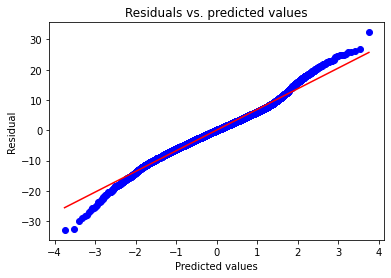

In [45]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)   

QQ plot is fairly linear

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


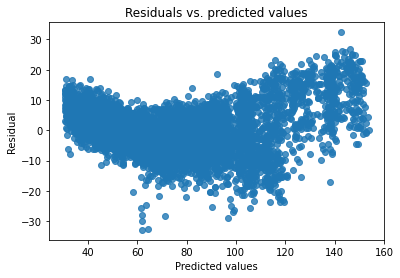

In [46]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score) 

This plot looks reasonable. The residual values appear to have a fairly constant dispersion as the predicted value changes. A few large residuals are noticeable, particularly on the positive side.